# <div style="text-align:center; color:rgba(37, 40, 80);">11752 Machine Learning</div>
# <div style="text-align:center; color:rgba(37, 40, 80);">Master in Intelligent Systems</div>
# <div style="text-align:center; color:rgba(37, 40, 80);">Universitat de les Illes Balears</div>

### <div style="text-align:center; color:white;"> Handout #3: **Instance-based learning**</div>

#### **Integrants:** Jason Adel Noboa Rivera, Pedro Marti Pico
#### **Group:** 07





In [17]:
import numpy as np
import cvxpy as cp
from sklearn import svm

import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from sklearn.metrics.pairwise import rbf_kernel
import copy

group = '07' 

In [3]:
def build_H(X, y): #Function to calculate the H matrix 
    H = []
    for x1, y1 in zip(X,y):
        rows = []
        for x2, y2 in zip(X,y):
            value = (y1 * y2 * np.dot(x1, x2)).item()
            rows.append(value)
        H.append(rows)
    return H

def calculate_w(X,y,lm): #Function to calculate w from landa's values
    index = [i for i, lamb in enumerate(lm) if lamb[0] > 1e-6] 
    w = [0,0]
    for i in index:
        w += np.multiply(lm[i]*y[i],X[i])
    return w

def calculate_w0(X,y,w,lm): #Function to calculate w0 from landa's values
    index = [i for i, lamb in enumerate(lm) if lamb[0] > 1e-6]
    w0 = [0]
    for i in index:
        w0 += y[i] - w @ X[i].T #Formula is yi - w.Txi but we did in this way beacuse the disposition of the samples
    return w0/len(index)
    
def plot_class(c, X, y): #Function to plot class
    m1 = ['k', 'w']
    m2 = ['x', 'x']
    i = np.where(y == c)[0]
    plt.scatter(X[i, 0], X[i, 1], c=m1[c], marker=m2[c], label=f'w{c+1}')

def predictQPS(w, w0, x): #Function to predict the class with QPS
    value = w[0]*x[0] + w[1]*x[1] + w0[0] 
    if value < 0:
        value = [-1]
    else:
        value = [1]
        
    return value
    

##### T1. **Given dataset dsgg1.txt:**

a)	Solve for the SVM analytically using the Karush-Kuhn-Tucker conditions and the Wolfe dual representation making use of the quadratic programming solver and:

•	find and report the support vectors (NOTE: due to round-off errors, it is likely none of the $λ_i$ are exactly 0, but close, e.g. $10^{-6}$), and

•	calculate and report the resulting decision function $g(x)= w^T x+w_0.$

In [4]:
'''
1. commented source code
2. support vectors
3. decision function 
'''
#Import data
task = 1
data = np.loadtxt('ds'+group+str(task)+'.txt')
X = data[:,0:2]
oy = data[:,2:3] #CLass labels are 1 for w1 and 0 for w2

y = copy.deepcopy(oy)

for i in y:
    if i[0] == 0:
        i[0] = -1 #Change -1 instead 0 to execute the solver otherwise solver didn't work

#Code from slides
N = X.shape[0]
P = build_H(X,y)
G = -np.identity(N)
h = np.zeros((N,1))
A = y.reshape((1,N))
b = 0.0
z = cp.Variable((N,1))
P = P + (1e-8) * np.identity(N) # for numerical stability
prob = cp.Problem(cp.Minimize(0.5*cp.quad_form(z,P) - cp.sum(z)), 
                  [G @ z <= h, A @ z == b])
prob.solve(solver = cp.ECOS)
#print(prob.status)
lm = z.value  #This are landas

'''Support Vectors'''
index = [i for i, lamb in enumerate(lm) if lamb[0] > 1e-6] #Index of values different of 0
sv_sqp = X[index] #Obtain the support vectors
print(f"Support Vectors:\n {sv_sqp}")

'''Decision function'''
#Calculate w and w0 from landa's values
w_sqp = calculate_w(X,y,lm)
w0_sqp = calculate_w0(X,y,w_sqp,lm)

#print(f"w = {(w.round(5))}")
#print(f"w0 = {(w0.round(5))}")
print(f'\ng(x) = {w_sqp[0].round(5)}x1 + {w_sqp[1].round(5)}x2 + {w0_sqp[0].round(5)}')


Support Vectors:
 [[-0.82782933 -0.56098003]
 [-3.89957879  2.18935727]
 [ 0.2668493   1.38880936]]

g(x) = 0.61119x1 + 0.68261x2 + -0.11111


b)	Generate the following plots:

•	a first plot with the training samples, highlighting the support vectors and plotting the 2D decision curve

•	a second plot with the classification map, i.e. evaluate the decision function for a 'regular' subset (grid) of points of the feature space
Use different markers and/or colours for each class.


In [5]:
#Plot Functions
def plot_data(X,y):
    y = np.squeeze(y)

    '''Plot the samples'''
    X1 = X[y == 1.0]  #Points of class w1
    X2 = X[y == -1.0]  #Points of class w2

    plt.scatter(X1[:, 0], X1[:, 1], color='red', marker='x', label='W1')  #Plot points of class w1
    plt.scatter(X2[:, 0], X2[:, 1], color='green', marker='x', label='W2')  #Plot points of class w2

    plt.xlabel('$X_1$')
    plt.ylabel('$X_2$')
    plt.legend()
    plt.show()
    
def plot_decision_func(X, y, sv, w, w0, type:str):

    '''Add the circles in supported vector machines'''
    for loc in sv: #Locate the support vectors stored in sv
        px, py = loc
        circle = Circle((px,py), 0.2, fill=False)
        plt.gca().add_patch(circle)

    # Set the limits of the axes for better visualization
    plt.xlim([-6, 6])
    plt.ylim([-6, 6])

    '''Add the decision curve'''
    #Create x values
    x_values = np.linspace(-10, 10, 10)

    # calculate corresponding y values with decision function
    y_values = (-w[0] / w[1]) * x_values - w0[0] / w[1]

    # add the decission line to the plot
    plt.plot(x_values, y_values)

    '''Add the segmented lines'''
    #Calculate the distance of the segmented line: 1/||w||
    d = 1/np.linalg.norm(w) 

    #Calculate y values for the segmented lines
    y_values_segmented_line1 = y_values + d / np.sqrt(w[0]**2 + w[1]**2)
    y_values_segmented_line2 = y_values - d / np.sqrt(w[0]**2 + w[1]**2)

    #Add the segmented lines to the plot
    plt.plot(x_values, y_values_segmented_line1, '--', color = 'grey')
    plt.plot(x_values, y_values_segmented_line2, '--', color = 'grey')

    if type == 'SQP':
        plt.title(f'Quadratic Programming Solver\ng(x) = {w[0].round(4)}x1 + {w[1].round(4)}x2 + {w0[0].round(4)}', fontsize = 6 )
    elif type == 'SVC':
        plt.title(f'SVC Object\ng(x) = {w[0].round(4)}x1 + {w[1].round(4)}x2 + {w0[0].round(4)}', fontsize = 6 )

    plot_data(X, y)
    #plt.legend()
    #plt.show()

def plot_classification_map(X, w, w0, type, model=None):
    '''Classification map'''
    #Code used from teacher in previous handout
    x1lim = [X[:, 0].min(), X[:, 0].max()]
    x2lim = [X[:, 1].min(), X[:, 1].max()]

    npts = 100
    x1s = np.linspace(x1lim[0], x1lim[1], npts)
    x2s = np.linspace(x2lim[0], x2lim[1], npts)

    if type == 'SVC':
        model = model

    m = np.zeros((npts, npts))
    for k1, x1 in enumerate(x1s):
        for k2, x2 in enumerate(x2s):
            x = np.array([x1, x2])
            if type == 'SVC':
                prediction = model.predict([x]) # For fix the deprecation error
            else:
                prediction = predictQPS(w,w0,x) #Predict the model with our function
            m[k1, k2] = prediction[0]

    plt.figure()
    plt.imshow(m.T, cmap='RdYlGn', origin='lower', extent=(x1lim[0]-1, x1lim[1]+1, x2lim[0]-1, x2lim[1]+1))
    for c in range(2):  # Assuming binary classification. Change if more classes.
        plot_class(c, X, oy)
    plt.xlabel('$X_1$')
    plt.ylabel('$X_2$')
    plt.legend()
    plt.show()

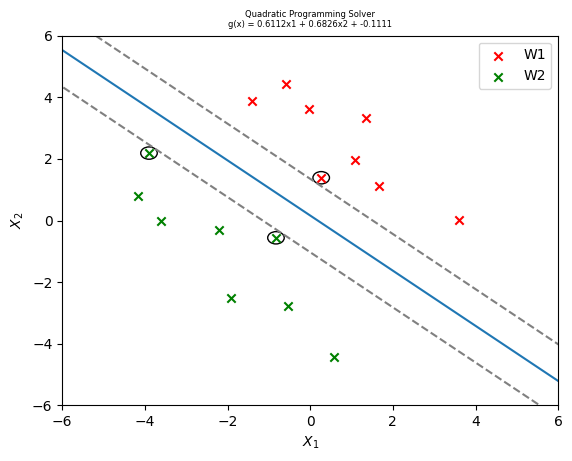

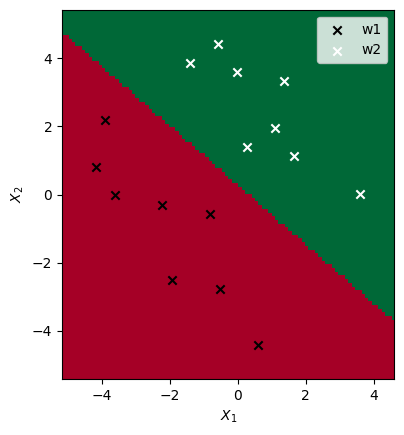

In [6]:
'''
1. commented source code
2. plot with samples and contour corresponding to the decision function
3. classification map
'''
plot_decision_func(X,y,sv_sqp,w_sqp,w0_sqp,'SQP')
plot_classification_map(X,w_sqp,w0_sqp,'SQP')

c)	Compare the results obtained with the ones resulting from the scikit-learn SVC object: i.e. report the support vectors returned by SVC and the corresponding decision function.

Support Vectors:
 [[-0.82782933 -0.56098003]
 [-3.89957879  2.18935727]
 [ 0.2668493   1.38880936]]

g(x) = 0.61098x1 + 0.68238x2 + -0.11119


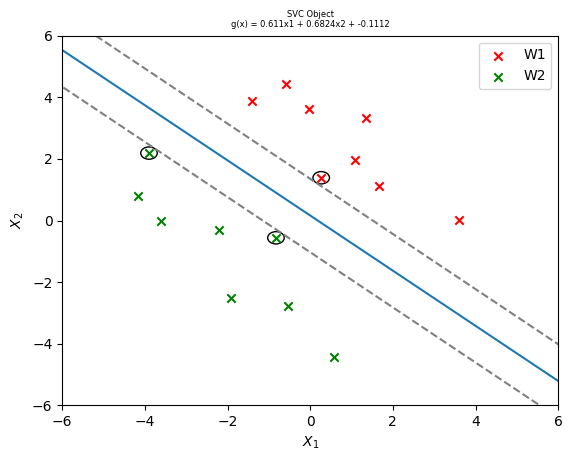

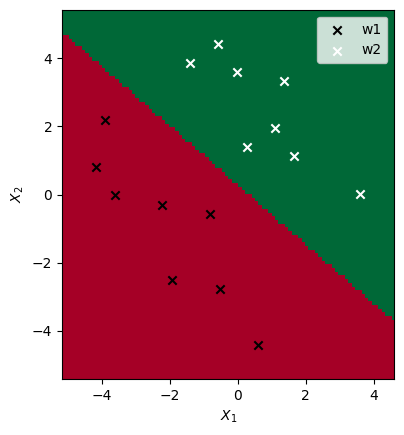

                                 MODEL COMPARATION                                
----------------------------------------------------------------------------------
                SQP Model               |                SVC Model                
                                 Support Vectors                                  
       [-0.82782933 -0.56098003]        |          [-0.82782933 -0.56098003]         
       [-3.89957879  2.18935727]        |          [-3.89957879  2.18935727]         
        [0.2668493  1.38880936]         |           [0.2668493  1.38880936]      
                               Decision function                 
g(x) = 0.61119x1 + 0.68261x2 + -0.11111 | g(x) = 0.61098x1 + 0.68238x2 + -0.11119


In [7]:
'''
1. commented source code
2. support vectors
3. decision function
4. plot with samples and contour corresponding to the decision function
5. classification map
'''
y = np.squeeze(y)

clf = svm.SVC(C = 1e16, kernel = 'linear')
clf.fit(X, y)

sv = clf.support_vectors_
w = clf.coef_.flatten()
w0 = clf.intercept_
lm = clf.dual_coef_.flatten()

print(f"Support Vectors:\n {sv}")
print(f'\ng(x) = {w[0].round(5)}x1 + {w[1].round(5)}x2 + {w0[0].round(5)}')

plot_decision_func(X,y,sv,w,w0,'SVC')
plot_classification_map(X,w,w0,'SVC',clf)

#Comparation between both models
print("                                 MODEL COMPARATION                                ")
print("----------------------------------------------------------------------------------")
print("                SQP Model               |                SVC Model                ")
print("                                 Support Vectors                                  ")
print(f"       {sv_sqp[0]}        |          {sv[0]}         ")
print(f"       {sv_sqp[1]}        |          {sv[1]}         ")
print(f"        {sv_sqp[2]}         |           {sv[2]}      ")
print("                               Decision function                 ")
print(f'g(x) = {w_sqp[0].round(5)}x1 + {w_sqp[1].round(5)}x2 + {w0_sqp[0].round(5)} | g(x) = {w[0].round(5)}x1 + {w[1].round(5)}x2 + {w0[0].round(5)}')



##### T2. **Given dataset dsgg2.txt:**

a)Mapping the training samples $x=(x_1,x_2)$ onto an alternative 2-dimensional space using $Φ(x)=(x_1 x_2,{x_1}^2+{x_2}^2)$, solve for the SVM analytically using the quadratic programming solver and

  •	find and report the support vectors in the original space, and

  •	calculate and report the resulting decision function both in the transformed space          $g_1(x')=w^T x'+w_0 [x'=Φ(x)]$ and in the original space $g_2 (x)=w^T Φ(x)+w_0$.

In [21]:
'''
1. commented source code
2. support vectors
3. decision functions
'''
#Import data
task = 2
data = np.loadtxt('ds'+group+str(task)+'.txt')
X = data[:,0:2]
oy = data[:,2:3] #CLass labels are 1 for w1 and 0 for w2

y = copy.deepcopy(oy)

# Convert the labels to -1 y 1
y = np.where(y == 0, -1, 1)

#Building kernel matrix
gamma = 0.1
K = np.outer(y,y)*rbf_kernel(X,X,gamma)

# Cuadratic problem configuration
N = X.shape[0]
lambda_var = cp.Variable(N)
P = cp.Parameter((N, N), PSD=True)
P.value = K
q = -np.ones(N)
G = -np.eye(N)
h = np.zeros(N)
A = y.reshape(1, -1)
b = np.zeros(1)

#Defining the problem
problem = cp.Problem(cp.Minimize((1/2)*cp.quad_form(lambda_var, P) + q.T @ lambda_var),
                     [G @ lambda_var <= h, A @ lambda_var == b])

problem.solve() # Resolve the problem
lambdas = lambda_var.value # Extracting lambda vector
sv_indices = np.where(lambdas > 1e-5)[0] #Identification of support vectors

# Calction of w0 using a support vectorutilizando un vector de soporte
selected_sv = sv_indices[0]
w0 = 1/y[selected_sv] - np.sum(lambdas[sv_indices] * K[selected_sv, sv_indices])

# Visualisation grid
xx, yy = np.meshgrid(np.linspace(X[:, 0].min()-1, X[:, 0].max()+1, 500),
                     np.linspace(X[:, 1].min()-1, X[:, 1].max()+1, 500))

# Evaluation of decision function in the grid
Z = np.sum(lambdas[sv].astype(int) * sv_indices * rbf_kernel(X[sv].astype(int), X)) + w0
Z = Z.reshape(xx.shape)

# Visualización
plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, levels=[-1, 0, 1], alpha=0.8, linestyles=['--', '-', '--'])
plt.scatter(X[:, 0], X[:, 1], c=oy, cmap=plt.cm.coolwarm, s=50, edgecolors='k')
plt.scatter(X[sv_indices, 0], X[sv_indices, 1], s=100, linewidth=1, facecolors='none', edgecolors='k')
plt.title("SVM no lineal con Kernel RBF")
plt.xlabel('Característica 1')
plt.ylabel('Característica 2')
plt.show()

c:\Users\ca01770\Anaconda3\envs\AIV_UIB\Lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:226: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(DPP_ERROR_MSG)


IndexError: arrays used as indices must be of integer (or boolean) type

In [9]:
#This is a non-linear SVM problem

b)	Generate the following plots:

•	a first plot with the training samples in the transformed space, highlighting the support vectors and plotting the 2D decision curve;

•	a second plot with the training samples in the original space, highlighting the support vectors and plotting the 2D decision curve; and

•	a third plot with the classification map in the original space, i.e. evaluate the decision function for a ’regular’ subset (grid) of points.


In [10]:
'''
Use different markers and/or colours for each class.
1. commented source code
2. plots with samples and contour corresponding to the decision function
3. classification map
'''

'\nUse different markers and/or colours for each class.\n1. commented source code\n2. plots with samples and contour corresponding to the decision function\n3. classification map\n'

c)	Compare the results obtained with the ones resulting from the scikit-learn SVC object: i.e. report the support vectors returned by SVC and the corresponding decision function.

In [11]:
'''
1. commented source code
2. support vectors
3. decision function
4. plot with samples and contour corresponding to the decision function
5. classification map
'''

'\n1. commented source code\n2. support vectors\n3. decision function\n4. plot with samples and contour corresponding to the decision function\n5. classification map\n'

d) Also by means of the scikit-learn SVC object, repeat point c) for the 'rbf' kernel. Additionally, draw the corresponding RBF network (slide 42 of the SVM lecture notes, replacing $K(x_i,x)$, $λ_i$ and $y_i$ by your values).

In [12]:
'''
1. commented source code
2. support vectors
3. plot with samples and contour corresponding to the decision function
4. classification map
5. RBF network
'''

'\n1. commented source code\n2. support vectors\n3. plot with samples and contour corresponding to the decision function\n4. classification map\n5. RBF network\n'

##### T3. **T3.	Given dataset dsgg3tr.txt/dsgg3te.txt**, find a suitable k-Nearest Neighbour (k-NN) classifier to adequately address the involved task.

a) Define the design strategy: combinations of hyper-parameters considered (number of neighbours and distance function), tuning approach (folds and repetitions).

b)	Using the training dataset, find the best performing classifier according to the design strategy and employing the accuracy as performance metric for the cross-validation process.

In [13]:
'''
1. commented source code (for a & b above)
2. resulting configuration
'''

'\n1. commented source code (for a & b above)\n2. resulting configuration\n'

c)	Plot the training samples on top of the classification map, i.e. evaluate the decision function for a ’regular’ subset (grid) of points of the feature space (use different markers and/or colours for each class).

In [14]:
'''
1. commented source code
2. classification map with training samples plotted
'''

'\n1. commented source code\n2. classification map with training samples plotted\n'

d)	Report on the classifier performance using the test dataset:

•	measure the test accuracy, test precision, test recall and test f1-score, and

•	in a single figure, plot the test samples over the already calculated classification map (use different markers and/or colours for each class).


In [15]:
'''
1. commented source code
2. test accuracy, test precision, test recall and test f1-score
3. classification map with test samples plotted
'''

'\n1. commented source code\n2. test accuracy, test precision, test recall and test f1-score\n3. classification map with test samples plotted\n'

e)	Obtain an improved estimation of the accuracy, precision, recall and f1-score measures by means of repeated, n-fold cross-validation. To this end, put together the training and test datasets, so that the corresponding function can build the folds from all available data.

In [16]:
'''
1. commented source code
2. accuracy, precision, recall and f1-score
'''

'\n1. commented source code\n2. accuracy, precision, recall and f1-score\n'